# Mass Produced Calculation

Batch time 100 hrs

In [1]:
import openmc
import openmc.deplete 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi
import xml.etree.ElementTree as et

In [2]:
# define materials

water = openmc.Material(name='water')
water.set_density('g/cc',0.989) # density of water at 320K (steady state operating temp of TRIGA)
water.add_element('H',2.0)
water.add_element('O',1.0)
water.add_s_alpha_beta('c_H_in_H2O')

pipe = openmc.Material(name = 'steel') # 304L Stainless steel from PNNL material Compendium
pipe.set_density('g/cc', 8.0)
pipe.add_element('C',0.000687)
pipe.add_element('Si',0.009793)
pipe.add_element('P',0.000408)
pipe.add_element('S',0.000257)
pipe.add_element('Cr',0.201015)
pipe.add_element('Mn',0.010013)
pipe.add_element('Fe',0.684101)
pipe.add_element('Ni',0.093725)


target = openmc.Material(name='target')
target.set_density('g/cc', 0.432)
target.add_nuclide('Np237', 1.0)
target.add_element('H', 1.0)
target.add_element('N', 1.0)
target.add_element('O', 3.0)

# add trace amount of Np238, Pu238, and Pu236 so depletion works...
target.add_nuclide('Np238',1e-18)
target.add_nuclide('Pu238',1e-18)
target.add_nuclide('Pu236',1e-18)

target.depletable = True

In [3]:
target_d = 5.0 # cm, diameter of target pin

pin_wall_thickness = 0.5 # cm

pitch = target_d + pin_wall_thickness + 10.0 # cm, lattice pitch.

height = 10.0 # cm, cell height

# define surfaces
# infinite prism along the z-axis, pitch x pitch square
cell_prism = openmc.model.rectangular_prism(pitch,pitch,
                                            boundary_type='vacuum')

cell_top = openmc.ZPlane(z0=height/2,boundary_type='reflective')
cell_bottom = openmc.ZPlane(z0=-height/2.,boundary_type='reflective')
clad_o = openmc.ZCylinder(r=(target_d+2.*pin_wall_thickness)/2.)
target_o = openmc.ZCylinder(r=target_d/2.)

# define regions
target_region = -target_o & -cell_top & +cell_bottom
clad_region = -clad_o & +target_o & -cell_top & +cell_bottom

# note the object cell_prism refers to the inside of the prism
mod_region = +clad_o & cell_prism & -cell_top & +cell_bottom

# define cells
target_c = openmc.Cell(name='target')
target_c.fill = target
target_c.region = target_region

clad_c = openmc.Cell(name='clad')
clad_c.fill = pipe
clad_c.region = clad_region

mod_c = openmc.Cell(name='mod')
mod_c.fill = water
mod_c.region = mod_region

# define the universe
root_univ = openmc.Universe()
root_univ.add_cells([target_c,clad_c,mod_c])

geometry = openmc.Geometry()
geometry.root_universe = root_univ
geometry.export_to_xml()

target.volume = np.pi*((target_d**2)/4.)*height;

materials = openmc.Materials([water,pipe,target])
materials.export_to_xml()

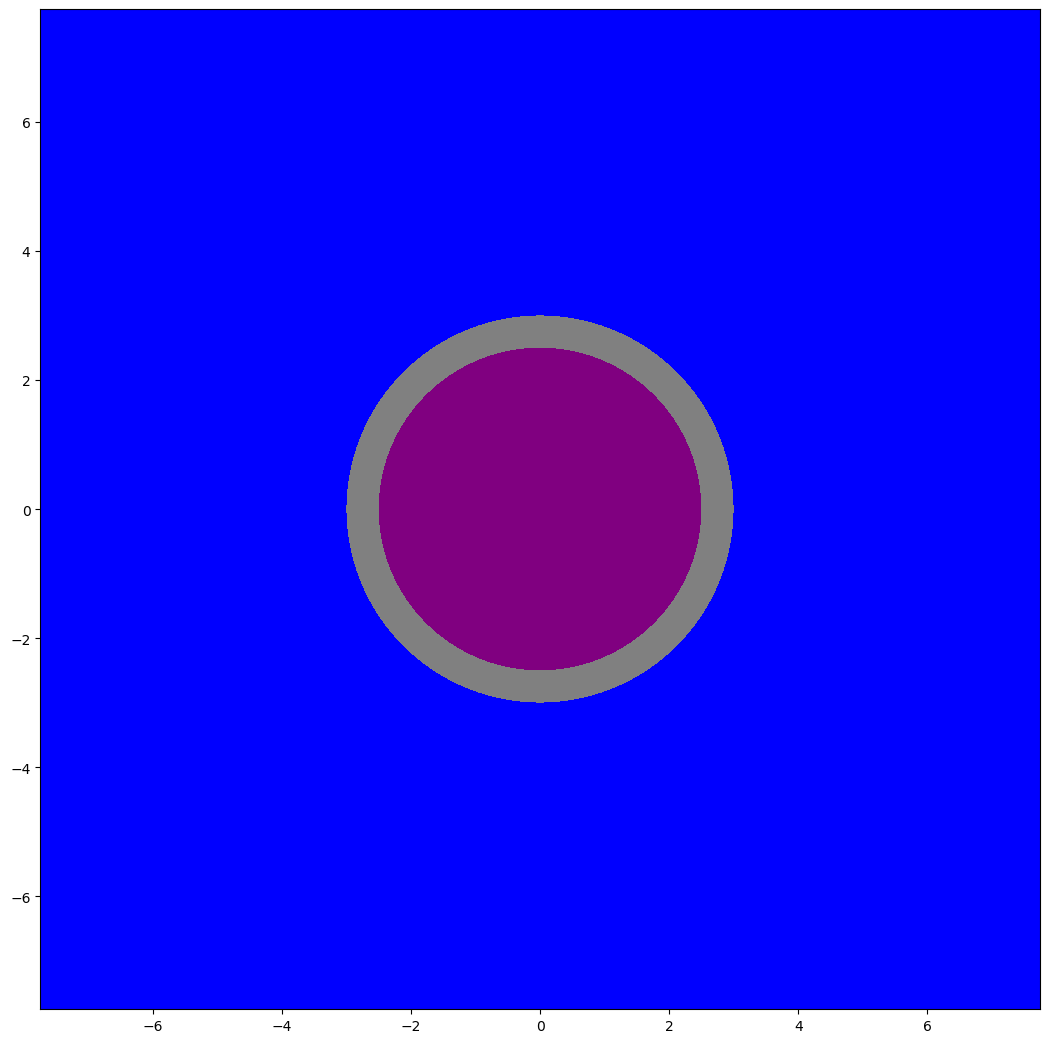

In [4]:
# plot root universe

colors = {}
colors[water]='blue'
colors[pipe]='gray'
colors[target]='purple'
root_univ.plot(origin=(0,0,0),width=(pitch,pitch),
               pixels=(1000,1000),color_by='material',
               basis='xy',colors=colors)

In [5]:
# define the source(s)


temp = 20 + 273.15; # in K
ev_K = 8.61732814974056E-05
f_maxwell = temp*ev_K # eV, 
#f_maxwell = 2.37e23; # eV

energy_sp = openmc.stats.Watt();

# spatial distribution of the 4 walls
# left wall: 
sp_left = openmc.stats.CartesianIndependent(x=openmc.stats.Discrete(-pitch/2.+1e-3,1),
                                           y=openmc.stats.Uniform(-pitch/2.,pitch/2.),
                                           z=openmc.stats.Uniform(-height/2.,height/2.));
#right wall:
#sp_right = openmc.stats.CartesianIndependent(x=openmc.stats.Discrete(pitch/2.-1e-3,1.0),
#                                           y=openmc.stats.Uniform(-pitch/2.,pitch/2.),
#                                           z=openmc.stats.Uniform(-height/2.,height/2.));

# "top" wall:
#sp_top = openmc.stats.CartesianIndependent(x=openmc.stats.Uniform(-pitch/2.,pitch/2.),
#                                           y=openmc.stats.Discrete(pitch/2.-1e-3,1.0),
#                                           z=openmc.stats.Uniform(-height/2.,height/2.));

# "bottom" wall:
#sp_bottom = openmc.stats.CartesianIndependent(x=openmc.stats.Uniform(-pitch/2.,pitch/2.),
#                                           y=openmc.stats.Discrete(-pitch/2.+1e-3,1),
#                                           z=openmc.stats.Uniform(-height/2.,height/2.));

s_left = openmc.Source(space=sp_left,
                      angle=openmc.stats.Monodirectional((1.0,0.0,0.0)),
                       energy=energy_sp) 

#s_right = openmc.Source(space=sp_right,
#                      angle=openmc.stats.Monodirectional((-1.0,0.0,0.0)),
#                       energy=energy_sp)
#
#s_top = openmc.Source(space=sp_top,
#                      angle=openmc.stats.Monodirectional((0.0,-1.0,0.0)),
#                       energy=energy_sp)

#s_bottom = openmc.Source(space=sp_bottom,
#                      angle=openmc.stats.Monodirectional((0.0,1.0,0.0)),
#                       energy=energy_sp)

In [6]:
# settings

settings = openmc.Settings() # create openmc settings object
#energy = openmc.stats.Watt() # create energy spectrum of particles
#settings.source = [s_left, s_right, s_top, s_bottom]
settings.source = [s_left]
settings.run_mode = 'fixed source'
settings.batches = 200
settings.inactive = 50
settings.particles = 300000
settings.generations_per_batch = 1

settings.export_to_xml()

In [7]:
model = openmc.model.Model(geometry,materials,settings)

operator = openmc.deplete.CoupledOperator(model,chain_file="chain_endfb71_pwr.xml",
                                         normalization_mode='source-rate');

# Assume a flux of 1e14 n/cm^2-s
avg_flux = 1.0e14; # n/cm^2-s
source_rate = height*pitch*avg_flux; # n/s
hours = 3600;
time_steps = [5000*hours];

cecm = openmc.deplete.PredictorIntegrator(operator,time_steps,
                                    source_rates=source_rate);


repeat_depletion = True;

if(repeat_depletion):
    cecm.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mg24 from /home/m231326/omc_data/endfb71_hdf5/Mg24.h5
 Reading Mg25 from /home/m231326/omc_data/endfb71_hdf5/Mg25.h5
 Reading Mg26 from /home/m231326/omc_data/endfb71_hdf5/Mg26.h5
 Reading Al27 from /home/m231326/omc_data/endfb71_hdf5/Al27.h5
 Reading Cl35 from /home/m231326/omc_data/endfb71_hdf5/Cl35.h5
 Reading Cl37 from /home/m231326/omc_data/endfb71_hdf5/Cl37.h5
 Reading Ar36 from /home/m231326/omc_data/endfb71_hdf5/Ar36.h5
 Reading Ar38 from /home/m231326/omc_data/endfb71_hdf5/Ar38.h5
 Reading Ar40 from /home/m231326/omc_data/endfb71_hdf5/Ar40.h5
 Reading K39 from /home/m231326/omc_data/endfb71_hdf5/K39.h5
 Reading K40 from /home/m231326/omc_data/endfb71_hdf5/K40.h5
 Reading K41 from /home/m231326/omc_data/endfb71_hdf5/K41.h5


 Reading Ca40 from /home/m231326/omc_data/endfb71_hdf5/Ca40.h5
 Reading Ca42 from /home/m231326/omc_data/endfb71_hdf5/Ca42.h5
 Reading Ca43 from /home/m231326/omc_data/endfb71_hdf5/Ca43.h5
 Reading Ca44 from /home/m231326/omc_data/endfb71_hdf5/Ca44.h5
 Reading Ca46 from /home/m231326/omc_data/endfb71_hdf5/Ca46.h5
 Reading Ca48 from /home/m231326/omc_data/endfb71_hdf5/Ca48.h5
 Reading Sc45 from /home/m231326/omc_data/endfb71_hdf5/Sc45.h5
 Reading Ti46 from /home/m231326/omc_data/endfb71_hdf5/Ti46.h5
 Reading Ti47 from /home/m231326/omc_data/endfb71_hdf5/Ti47.h5
 Reading Ti48 from /home/m231326/omc_data/endfb71_hdf5/Ti48.h5
 Reading Ti49 from /home/m231326/omc_data/endfb71_hdf5/Ti49.h5
 Reading Ti50 from /home/m231326/omc_data/endfb71_hdf5/Ti50.h5
 Reading V50 from /home/m231326/omc_data/endfb71_hdf5/V50.h5
 Reading V51 from /home/m231326/omc_data/endfb71_hdf5/V51.h5
 Reading Co58 from /home/m231326/omc_data/endfb71_hdf5/Co58.h5
 Reading Co58_m1 from /home/m231326/omc_data/endfb71_hdf5/C

 Reading Se80 from /home/m231326/omc_data/endfb71_hdf5/Se80.h5
 Reading Se82 from /home/m231326/omc_data/endfb71_hdf5/Se82.h5
 Reading Br79 from /home/m231326/omc_data/endfb71_hdf5/Br79.h5
 Reading Br81 from /home/m231326/omc_data/endfb71_hdf5/Br81.h5
 Reading Kr78 from /home/m231326/omc_data/endfb71_hdf5/Kr78.h5
 Reading Kr80 from /home/m231326/omc_data/endfb71_hdf5/Kr80.h5
 Reading Kr82 from /home/m231326/omc_data/endfb71_hdf5/Kr82.h5
 Reading Kr83 from /home/m231326/omc_data/endfb71_hdf5/Kr83.h5
 Reading Kr84 from /home/m231326/omc_data/endfb71_hdf5/Kr84.h5
 Reading Kr85 from /home/m231326/omc_data/endfb71_hdf5/Kr85.h5
 Reading Kr86 from /home/m231326/omc_data/endfb71_hdf5/Kr86.h5
 Reading Rb85 from /home/m231326/omc_data/endfb71_hdf5/Rb85.h5
 Reading Rb86 from /home/m231326/omc_data/endfb71_hdf5/Rb86.h5
 Reading Rb87 from /home/m231326/omc_data/endfb71_hdf5/Rb87.h5
 Reading Sr84 from /home/m231326/omc_data/endfb71_hdf5/Sr84.h5
 Reading Sr86 from /home/m231326/omc_data/endfb71_hdf5/

 Reading Mo96 from /home/m231326/omc_data/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/m231326/omc_data/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/m231326/omc_data/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/m231326/omc_data/endfb71_hdf5/Mo99.h5
 Reading Mo100 from /home/m231326/omc_data/endfb71_hdf5/Mo100.h5


 Reading Tc99 from /home/m231326/omc_data/endfb71_hdf5/Tc99.h5
 Reading Ru96 from /home/m231326/omc_data/endfb71_hdf5/Ru96.h5
 Reading Ru98 from /home/m231326/omc_data/endfb71_hdf5/Ru98.h5
 Reading Ru99 from /home/m231326/omc_data/endfb71_hdf5/Ru99.h5
 Reading Ru100 from /home/m231326/omc_data/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/m231326/omc_data/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/m231326/omc_data/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/m231326/omc_data/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/m231326/omc_data/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/m231326/omc_data/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/m231326/omc_data/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/m231326/omc_data/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/m231326/omc_data/endfb71_hdf5/Rh105.h5
 Reading Pd102 from /home/m231326/omc_data/endfb71_hdf5/Pd102.h5
 Reading Pd104 from /home/m231326/omc_data/endfb71_hdf5/Pd104.h5
 Reading Pd105 from /home/m231326

          1200K
          2500K


 Reading Cd108 from /home/m231326/omc_data/endfb71_hdf5/Cd108.h5
 Reading Cd110 from /home/m231326/omc_data/endfb71_hdf5/Cd110.h5
 Reading Cd111 from /home/m231326/omc_data/endfb71_hdf5/Cd111.h5
 Reading Cd112 from /home/m231326/omc_data/endfb71_hdf5/Cd112.h5
 Reading Cd113 from /home/m231326/omc_data/endfb71_hdf5/Cd113.h5
 Reading Cd114 from /home/m231326/omc_data/endfb71_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/m231326/omc_data/endfb71_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/m231326/omc_data/endfb71_hdf5/Cd116.h5
 Reading In113 from /home/m231326/omc_data/endfb71_hdf5/In113.h5
 Reading In115 from /home/m231326/omc_data/endfb71_hdf5/In115.h5
 Reading Sn112 from /home/m231326/omc_data/endfb71_hdf5/Sn112.h5
 Reading Sn113 from /home/m231326/omc_data/endfb71_hdf5/Sn113.h5
 Reading Sn114 from /home/m231326/omc_data/endfb71_hdf5/Sn114.h5
 Reading Sn115 from /home/m231326/omc_data/endfb71_hdf5/Sn115.h5
 Reading Sn116 from /home/m231326/omc_data/endfb71_hdf5/Sn116.h5
 Reading Sn117 from

          1200K
          2500K


 Reading Sn126 from /home/m231326/omc_data/endfb71_hdf5/Sn126.h5
 Reading Sb121 from /home/m231326/omc_data/endfb71_hdf5/Sb121.h5
 Reading Sb123 from /home/m231326/omc_data/endfb71_hdf5/Sb123.h5
 Reading Sb124 from /home/m231326/omc_data/endfb71_hdf5/Sb124.h5
 Reading Sb125 from /home/m231326/omc_data/endfb71_hdf5/Sb125.h5
 Reading Sb126 from /home/m231326/omc_data/endfb71_hdf5/Sb126.h5
 Reading Te120 from /home/m231326/omc_data/endfb71_hdf5/Te120.h5
 Reading Te122 from /home/m231326/omc_data/endfb71_hdf5/Te122.h5
 Reading Te123 from /home/m231326/omc_data/endfb71_hdf5/Te123.h5
 Reading Te124 from /home/m231326/omc_data/endfb71_hdf5/Te124.h5
 Reading Te125 from /home/m231326/omc_data/endfb71_hdf5/Te125.h5


          1200K
          2500K


 Reading Te126 from /home/m231326/omc_data/endfb71_hdf5/Te126.h5
 Reading Te127_m1 from /home/m231326/omc_data/endfb71_hdf5/Te127_m1.h5
 Reading Te128 from /home/m231326/omc_data/endfb71_hdf5/Te128.h5
 Reading Te129_m1 from /home/m231326/omc_data/endfb71_hdf5/Te129_m1.h5
 Reading Te130 from /home/m231326/omc_data/endfb71_hdf5/Te130.h5
 Reading Te132 from /home/m231326/omc_data/endfb71_hdf5/Te132.h5
 Reading I127 from /home/m231326/omc_data/endfb71_hdf5/I127.h5
 Reading I129 from /home/m231326/omc_data/endfb71_hdf5/I129.h5
 Reading I130 from /home/m231326/omc_data/endfb71_hdf5/I130.h5
 Reading I131 from /home/m231326/omc_data/endfb71_hdf5/I131.h5
 Reading I135 from /home/m231326/omc_data/endfb71_hdf5/I135.h5
 Reading Xe123 from /home/m231326/omc_data/endfb71_hdf5/Xe123.h5


 Reading Xe124 from /home/m231326/omc_data/endfb71_hdf5/Xe124.h5
 Reading Xe126 from /home/m231326/omc_data/endfb71_hdf5/Xe126.h5
 Reading Xe128 from /home/m231326/omc_data/endfb71_hdf5/Xe128.h5
 Reading Xe129 from /home/m231326/omc_data/endfb71_hdf5/Xe129.h5
 Reading Xe130 from /home/m231326/omc_data/endfb71_hdf5/Xe130.h5
 Reading Xe131 from /home/m231326/omc_data/endfb71_hdf5/Xe131.h5
 Reading Xe132 from /home/m231326/omc_data/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/m231326/omc_data/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/m231326/omc_data/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/m231326/omc_data/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/m231326/omc_data/endfb71_hdf5/Xe136.h5
 Reading Cs133 from /home/m231326/omc_data/endfb71_hdf5/Cs133.h5


          2500K


 Reading Cs134 from /home/m231326/omc_data/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/m231326/omc_data/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/m231326/omc_data/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/m231326/omc_data/endfb71_hdf5/Cs137.h5
 Reading Ba130 from /home/m231326/omc_data/endfb71_hdf5/Ba130.h5
 Reading Ba132 from /home/m231326/omc_data/endfb71_hdf5/Ba132.h5
 Reading Ba133 from /home/m231326/omc_data/endfb71_hdf5/Ba133.h5


          1200K
          2500K


 Reading Ba134 from /home/m231326/omc_data/endfb71_hdf5/Ba134.h5
 Reading Ba135 from /home/m231326/omc_data/endfb71_hdf5/Ba135.h5
 Reading Ba136 from /home/m231326/omc_data/endfb71_hdf5/Ba136.h5
 Reading Ba137 from /home/m231326/omc_data/endfb71_hdf5/Ba137.h5
 Reading Ba138 from /home/m231326/omc_data/endfb71_hdf5/Ba138.h5
 Reading Ba140 from /home/m231326/omc_data/endfb71_hdf5/Ba140.h5
 Reading La138 from /home/m231326/omc_data/endfb71_hdf5/La138.h5
 Reading La139 from /home/m231326/omc_data/endfb71_hdf5/La139.h5
 Reading La140 from /home/m231326/omc_data/endfb71_hdf5/La140.h5
 Reading Ce136 from /home/m231326/omc_data/endfb71_hdf5/Ce136.h5
 Reading Ce138 from /home/m231326/omc_data/endfb71_hdf5/Ce138.h5
 Reading Ce139 from /home/m231326/omc_data/endfb71_hdf5/Ce139.h5
 Reading Ce140 from /home/m231326/omc_data/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/m231326/omc_data/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/m231326/omc_data/endfb71_hdf5/Ce142.h5
 Reading Ce143 from /home

          1200K
          2500K


 Reading Gd152 from /home/m231326/omc_data/endfb71_hdf5/Gd152.h5
 Reading Gd153 from /home/m231326/omc_data/endfb71_hdf5/Gd153.h5
 Reading Gd154 from /home/m231326/omc_data/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/m231326/omc_data/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/m231326/omc_data/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/m231326/omc_data/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/m231326/omc_data/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/m231326/omc_data/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/m231326/omc_data/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/m231326/omc_data/endfb71_hdf5/Tb160.h5
 Reading Dy156 from /home/m231326/omc_data/endfb71_hdf5/Dy156.h5
 Reading Dy158 from /home/m231326/omc_data/endfb71_hdf5/Dy158.h5
 Reading Dy160 from /home/m231326/omc_data/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/m231326/omc_data/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/m231326/omc_data/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home

 Reading Cf246 from /home/m231326/omc_data/endfb71_hdf5/Cf246.h5
 Reading Cf248 from /home/m231326/omc_data/endfb71_hdf5/Cf248.h5
 Reading Cf249 from /home/m231326/omc_data/endfb71_hdf5/Cf249.h5
 Reading Cf250 from /home/m231326/omc_data/endfb71_hdf5/Cf250.h5
 Reading Cf251 from /home/m231326/omc_data/endfb71_hdf5/Cf251.h5
 Reading Cf252 from /home/m231326/omc_data/endfb71_hdf5/Cf252.h5


          1200K


 Reading Cf253 from /home/m231326/omc_data/endfb71_hdf5/Cf253.h5
 Reading Cf254 from /home/m231326/omc_data/endfb71_hdf5/Cf254.h5
 Reading Es251 from /home/m231326/omc_data/endfb71_hdf5/Es251.h5
 Reading Es252 from /home/m231326/omc_data/endfb71_hdf5/Es252.h5
 Reading Es253 from /home/m231326/omc_data/endfb71_hdf5/Es253.h5
 Reading Es254 from /home/m231326/omc_data/endfb71_hdf5/Es254.h5
 Reading Es254_m1 from /home/m231326/omc_data/endfb71_hdf5/Es254_m1.h5
 Reading Es255 from /home/m231326/omc_data/endfb71_hdf5/Es255.h5
 Reading Fm255 from /home/m231326/omc_data/endfb71_hdf5/Fm255.h5
 Maximum neutron transport energy: 20000000 eV for H1

 ===============>     FIXED SOURCE TRANSPORT SIMULATION     <===============

 Simulating batch 1
 Simulating batch 2
 Simulating batch 3
 Simulating batch 4
 Simulating batch 5
 Simulating batch 6
 Simulating batch 7
 Simulating batch 8
 Simulating batch 9
 Simulating batch 10
 Simulating batch 11
 Simulating batch 12
 Simulating batch 13
 Simulating 

 Simulating batch 103
 Simulating batch 104
 Simulating batch 105
 Simulating batch 106
 Simulating batch 107
 Simulating batch 108
 Simulating batch 109
 Simulating batch 110
 Simulating batch 111
 Simulating batch 112
 Simulating batch 113
 Simulating batch 114
 Simulating batch 115
 Simulating batch 116
 Simulating batch 117
 Simulating batch 118
 Simulating batch 119
 Simulating batch 120
 Simulating batch 121
 Simulating batch 122
 Simulating batch 123
 Simulating batch 124
 Simulating batch 125
 Simulating batch 126
 Simulating batch 127
 Simulating batch 128
 Simulating batch 129
 Simulating batch 130
 Simulating batch 131
 Simulating batch 132
 Simulating batch 133
 Simulating batch 134
 Simulating batch 135
 Simulating batch 136
 Simulating batch 137
 Simulating batch 138
 Simulating batch 139
 Simulating batch 140
 Simulating batch 141
 Simulating batch 142
 Simulating batch 143
 Simulating batch 144
 Simulating batch 145
 Simulating batch 146
 Simulating batch 147
 Simulatin

In [8]:
r = openmc.deplete.Results('./depletion_results.h5')
burned_materials = r.export_to_materials(burnup_index=1)
burned_materials.export_to_xml('BurnedMaterials1.xml')

In [9]:
mat_tree = et.parse('BurnedMaterials1.xml')
root = mat_tree.getroot()
i=0
for child in root:
    if child.attrib['name']=='target':
        target_elem = root[i]
    i+=1

In [10]:
# create Material object from element in burned Materials object
target_elem.set('id',23)
#print(target_elem.items())
#type(target_elem)
burned_target = openmc.Material.from_xml_element(target_elem)
burned_target_mass = burned_target.get_mass()

print(burned_target)
print(burned_target_mass, 'g')

Material
	ID             =	23
	Name           =	target
	Temperature    =	None
	Density        =	None [sum]
	Volume         =	196.34954084936209 [cm^3]
	S(a,b) Tables  
	Nuclides       
	Ac225          =	3.071132234155508e-22 [ao]
	Ac226          =	1.7857246386682715e-25 [ao]
	Ac227          =	2.4738734009028256e-21 [ao]
	Ag107          =	2.011736810400931e-15 [ao]
	Ag109          =	3.119354940894664e-08 [ao]
	Ag110_m1       =	5.4519886475113275e-11 [ao]
	Ag111          =	4.6148411418235174e-10 [ao]
	Al27           =	9.999216193092923e-22 [ao]
	Am240          =	2.196483709750699e-18 [ao]
	Am241          =	1.3776694306330721e-10 [ao]
	Am242          =	2.1029860143859943e-13 [ao]
	Am242_m1       =	4.701061039204812e-13 [ao]
	Am243          =	9.678814704938254e-12 [ao]
	Am244          =	1.6251738887379415e-16 [ao]
	Am244_m1       =	1.0642993603588277e-16 [ao]
	Ar36           =	9.977789761694518e-22 [ao]
	Ar38           =	9.998474794851938e-22 [ao]
	Ar40           =	1.001360643514862e-21 [a

In [11]:
listnuc = burned_target.get_nuclides()
import re
Puiso = []
for nuclide in listnuc:
    if re.search('Pu.+', nuclide):
        Puiso.append(nuclide)

In [12]:
pu_mass =0.
for nuclide in Puiso:
    pu_mass+=burned_target.get_mass(nuclide=nuclide)
print(pu_mass, 'g')

pu_mass_fraction = pu_mass/burned_target_mass
print(pu_mass_fraction, 'pu mass/target mass')

5.129024173716529 g
0.06045337809930305 pu mass/target mass


In [13]:
# create metallic Pu from separated Pu product in Burned Fuel
SepPu = openmc.Material(name='PuProduct')
SepPu.set_density('g/cc',19.84) # density used for all metallic Plutonium in PNNL Compendium

print(Puiso)
i = len(Puiso)
n = 0
BurnPuAo = []
while (n < i):
    BurnPu = burned_target.get_nuclide_atom_densities(Puiso[n])
    BurnPuAo.append(BurnPu)
    SepPu.add_nuclide(Puiso[n],BurnPu[Puiso[n]])
    n+=1
#print(BurnPuAo)
#print(SepPu)

['Pu236', 'Pu237', 'Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242', 'Pu243', 'Pu244', 'Pu246']


In [14]:
# calculate mass of Pu-238 produced
coil_length = 2908; # coil length (cm)
model_factor = coil_length/height # number of models to one coil length

Pu238_mass_model = burned_target.get_mass('Pu238') # mass of pu238 per model length
Pu238_mass_batch = Pu238_mass_model*model_factor # mass of pu238 per batch (g)
print('The mass of Pu-238 produced in one batch is',Pu238_mass_batch,'g')

SepPuAo = SepPu.get_nuclide_atom_densities()

Pu238assay = (SepPuAo['Pu238'])/(SepPuAo['Pu236'] + SepPuAo['Pu237'] + SepPuAo['Pu238'] 
                                 + SepPuAo['Pu239'] + SepPuAo['Pu240'] + SepPuAo['Pu241'] 
                                 + SepPuAo['Pu242'] + SepPuAo['Pu243'] + SepPuAo['Pu244'] 
                                 + SepPuAo['Pu246'])
print('The product Pu-238 assay is',Pu238assay*100,'%')

Pu28_29 = (SepPuAo['Pu238']/SepPuAo['Pu239'])
print('The ratio of Pu238/Pu239 is',Pu28_29)

The mass of Pu-238 produced in one batch is 1402.4621291594733 g
The product Pu-238 assay is 94.05412412189278 %
The ratio of Pu238/Pu239 is 16.804026802699997
